<a href="https://colab.research.google.com/github/kenhuangsy/learning-tensorflow/blob/main/04_transfer_learning_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.



In [ ]:
# Are we using a GPU?
!nvidia-smi

Sun Oct 16 00:29:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-10-16 00:29:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   102MB/s    in 1.6s    

2022-10-16 00:29:40 (102 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?

import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

we'll use the 'ImageDataGenerator' class to load in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode = "categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with the **TensorBoard callback**
* Model checkpoint with the **ModelCheckpoint callback**
* Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping callback**

In [ ]:
import tensorflow as tf

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub, where pretrained models are stored

We are using the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"


In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url: str, num_classes = 10):
  """
  Takes a TensorFlow Hub Url and creates a Keras Sequential Model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
    should be equal to the number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable = False, # Freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE + (3,)) 

  # Create our own model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation = "softmax", name = "output_layer")
  ])

  return model


### Creating ResNet TensorFlow Hub Feature Extraction Model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes = 10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our ResNet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 10,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps =len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                           experiment_name = "resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221016-003618
Epoch 1/10
24/24 [==============================] - 29s 790ms/step - loss: 1.9096 - accuracy: 0.3560 - val_loss: 1.1763 - val_accuracy: 0.6348
Epoch 2/10
24/24 [==============================] - 18s 758ms/step - loss: 0.8992 - accuracy: 0.7373 - val_loss: 0.8233 - val_accuracy: 0.7476
Epoch 3/10
24/24 [==============================] - 17s 720ms/step - loss: 0.6211 - accuracy: 0.8347 - val_loss: 0.7305 - val_accuracy: 0.7752
Epoch 4/10
24/24 [==============================] - 17s 720ms/step - loss: 0.4670 - accuracy: 0.8893 - val_loss: 0.6891 - val_accuracy: 0.7816
Epoch 5/10
24/24 [==============================] - 17s 720ms/step - loss: 0.3783 - accuracy: 0.9227 - val_loss: 0.6690 - val_accuracy: 0.7828
Epoch 6/10
24/24 [==============================] - 17s 726ms/step - loss: 0.3061 - accuracy: 0.9453 - val_loss: 0.6456 - val_accuracy: 0.7868
Epoch 7/10
24/24 [==============================] - 18s 755ms/step 

Wow!

That is incredible! Our transfer learning feature extractor model outperforemd all of our previous models we built by hand and it is even faster AND with only 10% of our training data

In [ ]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

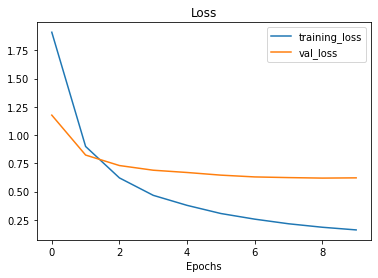

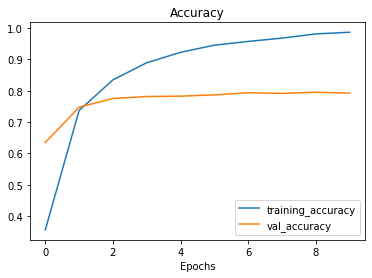

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
efficientnet_model = create_model(efficientnet_url,
                                  num_classes = 10)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = "Adam",
                           metrics = ["accuracy"])

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs = 10,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks=[create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                              experiment_name = "efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20221016-012724
Epoch 1/10
24/24 [==============================] - 16s 679ms/step - loss: 0.1218 - accuracy: 0.9960 - val_loss: 0.3890 - val_accuracy: 0.8764
Epoch 2/10
24/24 [==============================] - 16s 667ms/step - loss: 0.1147 - accuracy: 0.9933 - val_loss: 0.3856 - val_accuracy: 0.8776
Epoch 3/10
24/24 [==============================] - 16s 672ms/step - loss: 0.1066 - accuracy: 0.9960 - val_loss: 0.3845 - val_accuracy: 0.8772
Epoch 4/10
24/24 [==============================] - 16s 669ms/step - loss: 0.1003 - accuracy: 0.9973 - val_loss: 0.3830 - val_accuracy: 0.8772
Epoch 5/10
24/24 [==============================] - 16s 674ms/step - loss: 0.0949 - accuracy: 0.9973 - val_loss: 0.3800 - val_accuracy: 0.8768
Epoch 6/10
24/24 [==============================] - 17s 714ms/step - loss: 0.0895 - accuracy: 0.9973 - val_loss: 0.3801 - val_accuracy: 0.8780
Epoch 7/10
24/24 [==============================] - 16s 696ms/s

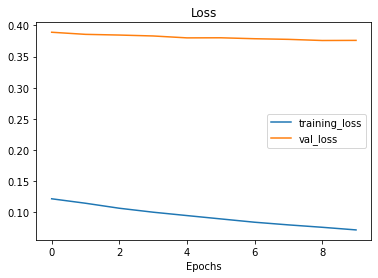

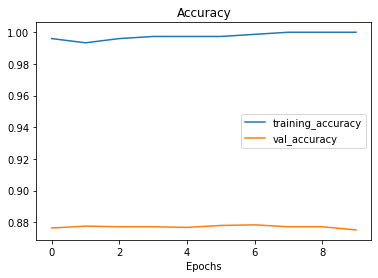

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes (e.g. using ImageNet model on 100 ImageNet classes -- none of your own)
* "Feature extraction" transfer learning -- use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output for your own problem (e.g. 1000 classes to 10 classes of food)
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers).

## Comparing our models' results using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you are running private experiments, then don't use tensorboard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=OCtEIUcD5sQne48OyZxiwNkfnQ6gYz&prompt=consent&access_type=off

Our tensorboard experiments are uploaded publicly here: https://tensorboard.dev/experiment/WH6vKQBgQGODtbLP1dPbNg/

In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/WH6vKQBgQGODtbLP1dPbNg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   WH6vKQBgQGODtbLP1dPbNg
	Created              2022-10-16 01:54:19 (3 minutes ago)
	Updated              2022-10-16 01:54:23 (3 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  4561041
Total: 1 experiment(s)
